# MCMC applications in Bayesian statistics

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/)  for the Vatican Observatory Summer School 2023, and it is available from [github](https://github.com/ivezic/IRB2023/blob/main/notebooks/IRBclass2.ipynb).

<a id='toc'></a>

## This notebook includes:

[Model selection example: finding bursts in time series](#MS1mcmc) 

[Bayesian Blocks Algorithm](#MS2mcmc)   

### Instead of using pymc3 as the last time, we will here use a much more light-weight emcee tool  

In [1]:
import emcee

##  Markov Chain Monte Carlo in Practice: PyMC vs. emcee

Quoting 
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

### emcee

* The emcee package (also known as MCMC Hammer, which is in the running for best Python package name in history) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".*

* Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

### PyMC3

* The PyMC3 package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC3 relies on the Theano library to construct probability distributions and then access the gradient in order to implement cutting edge inference algorithms. PyMC3 also provides several samplers. Unlike earlier version, it doesn't rely on complied fortran libraries, can be easily installed either by pip or conda.

More details about PyMC3 are available from [the pyMC3 User Guide](https://docs.pymc.io/)

### Recall "Bayesian Model Comparison" from Lecture 4:

To determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as
$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

The posterior probability that the model $M$ is correct given data $D$ is
$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$
and the odds ratio can ignore $p(D|I)$ since it will be the same for both models. 

We get 
$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} \equiv B_{21} \, \frac{p(M_2\,|\,I)}{p(M_1\,|\,I)},$$
where $B_{21}$ is called the Bayes factor. 

The Bayes factor compares how well the models fit the data: it is a ratio of data likelihoods averaged over 
all allowed values of the model parameters and computed as
$$B_{21} = \frac{\int p(D\,|\,M_2, \theta, I) \, p(\theta\,|\,M_2, I) \, d\theta}{\int p(D\,|\,M_1, \theta, I) \, p(\theta\,|\,M_1, I) \, d\theta}. $$
 
In other words, the Bayes factor is the ratio of **the global likelihoods for models $M_1$ and $M_2$**, 
where the global likelihood, or evidence, is a weighted average of the likelihood function, with the 
prior for model parameters acting as the weighting function.




## Example: unknown number of "bursts" in a time series - find out how many bursts in an and their best-fit model parameters.

### (note: a very similar example is the number of components in a spectrum...)

The flux vs. time plot further below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile 
$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 
for $t>T$. Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts. 

**Additional details:**
- there are no more than 2 bursts in this dataset
- we  can use flat priors for A and T and the background (non-bursting) flux level,
  and Jeffreys' prior for $\alpha$
- we can approximate model comparison based on the BIC 
- we can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)

##  Model selection example: finding bursts in time series<a id='MS1mcmc'></a>
[Go to top](#toc)

In [2]:
def OneBurst(t, b0, A, T, alpha):
    """a single exponential burst model"""
    yBurst = A * np.exp(-(t-T)/alpha)
    return np.where(t > T, b0+yBurst, b0)

def TwoBursts(t, b0, A1, T1, alpha1, A2, T2, alpha2):
    """two exponential bursts model"""
    yBurst1 = A1 * np.exp(-(t-T1)/alpha1)
    yBurst2 = A2 * np.exp(-(t-T2)/alpha2)
    y1 = np.where(t > T1, b0+yBurst1, b0)
    return np.where(t > T2, y1+yBurst2, y1)

In [3]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(42)

In [4]:
# BURST: input model parameters 
b0_true = 10
A1_true = 4
T1_true = 20
alpha1_true = 10
A2_true = 5
T2_true = 70
alpha2_true = 5

# generate data
Ndata = 200
t = 120 * np.random.random(Ndata)
xdata = np.sort(t) 
y_true = TwoBursts(xdata, b0_true, A1_true, T1_true, alpha1_true, A2_true, T2_true, alpha2_true)
thetaTrue = (b0_true, A1_true, T1_true, alpha1_true, A2_true, T2_true, alpha2_true)

# add scatter to points
yErr = 0.4 + 0.1*np.sqrt(y_true)    # worked with 0.2, 0.4, died with 0.5
ydata = np.random.normal(y_true, yErr)

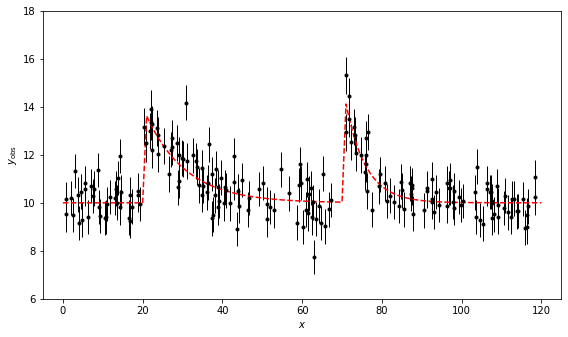

In [5]:
# Plot input data again, this time showing the true generative model
#  (which at the same time checks that the model and true params are set properly)
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 120, 121)
y_true = TwoBursts(t_fit, b0_true, A1_true, T1_true, alpha1_true, A2_true, T2_true, alpha2_true)

ax.errorbar(xdata, ydata, yErr, fmt='.', lw=1, c='k')
ax.plot(t_fit, y_true, '--', c='red')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

In [6]:
# Define our posterior using Python functions
# for clarity, I've separated-out the prior and likelihood
# but this is not necessary. Note that emcee requires log-posterior

def yModelSingle(x, theta):
    # this is where a model is chosen, and also the number 
    # of model parameters and their meaning set 
    b0 = theta[0]
    A = theta[1]
    T = theta[2]
    alpha = theta[3]
    return OneBurst(x, b0, A, T, alpha) 

def yModelDouble(x, theta):
    # this is where a model is chosen, and also the number 
    # of model parameters and their meaning set 
    b0 = theta[0]
    A1 = theta[1]
    T1 = theta[2]
    alpha1 = theta[3]
    A2 = theta[4]
    T2 = theta[5]
    alpha2 = theta[6]
    return TwoBursts(x, b0, A1, T1, alpha1, A2, T2, alpha2) 

def yModel(x, theta):
    return yModelDouble(x, theta)

LOGPRIOR_MIN = -np.inf 
#LOGPRIOR_MIN = -1.0e12

def log_flat_prior(theta, thetaMin, thetaMax):
    # logPriorMin = -np.inf  
    for k in range(np.size(theta)):
        if (theta[k]<thetaMin[k]): return LOGPRIOR_MIN 
        if (theta[k]>thetaMax[k]): return LOGPRIOR_MIN   
    return 1.0 
    
def log_prior(theta, thetaMin, thetaMax):
    return log_flat_prior(theta, thetaMin, thetaMax)

def log_likelihood(theta, x, y, yErr):
    # we are assuming that measurement errors are Gaussian and known
    # and thus ignoring normalization factors in the likelihood
    return -np.sum((y - yModel(x, theta)) ** 2 / yErr ** 2)

def log_posterior(theta, x, y, yErr, thetaMin, thetaMax):
    logLikelihood = log_likelihood(theta, x, y, yErr)
    logPrior = log_prior(theta, thetaMin, thetaMax)
    if logPrior > LOGPRIOR_MIN:
        return logPrior + logLikelihood
    else:
        return LOGPRIOR_MIN + logLikelihood 

In [7]:
# limits for flat priors
thetaMin =  (5,  0,  0,  2,  0,  20,  2)
thetaMax = (15, 10, 80, 20, 10, 100, 20)

# emcee combines multiple "walkers", each of which is its own MCMC chain. 
# The number of trace results will be nwalkers * nsteps
ndim = 7  # number of parameters in the model
nwalkers = 100  # number of MCMC walkers
# starting guesses for parameters 
np.random.seed(0)
starting_guesses = 0.1*np.random.random((nwalkers, ndim))
# set starting guesses at the center of flat priors
for k in range(np.size(thetaMin)):
    starting_guesses[:,k] += 0.5*(thetaMin[k]+thetaMax[k])

In [8]:
import emcee

In [9]:
nburn = 2000    # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take, about 1 min runtime
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[xdata, ydata, yErr, thetaMin, thetaMax])
%time sampler.run_mcmc(starting_guesses, nsteps) 
print("done")

CPU times: user 55.2 s, sys: 388 ms, total: 55.6 s
Wall time: 56.3 s
done


In [10]:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
thetaFit= []
for k in range(ndim):
    thetaFit.append(np.median(emcee_trace[k]))
    print(thetaTrue[k], np.median(emcee_trace[k]), np.std(emcee_trace[k]), np.size(emcee_trace[k]))

10 10.05268265645822 0.17206910057979138 800000
4 3.6585156011798703 1.3478548661587038 800000
20 20.007103618391724 14.027616415942736 800000
10 11.192790749586166 3.2758320649428594 800000
5 5.4687041738935305 2.293231891985416 800000
70 68.57605138643115 16.730470699748736 800000
5 5.239084831488966 3.485503435045568 800000


In [11]:
T1 = emcee_trace[2]
print(np.min(T1), np.median(T1), np.max(T1))

17.54620234515461 20.007103618391724 79.9944743837565


In [12]:
T2 = emcee_trace[5]
print(np.min(T2), np.median(T2), np.max(T2))

20.0001247822229 68.57605138643115 70.90710541809555


In [13]:
import corner

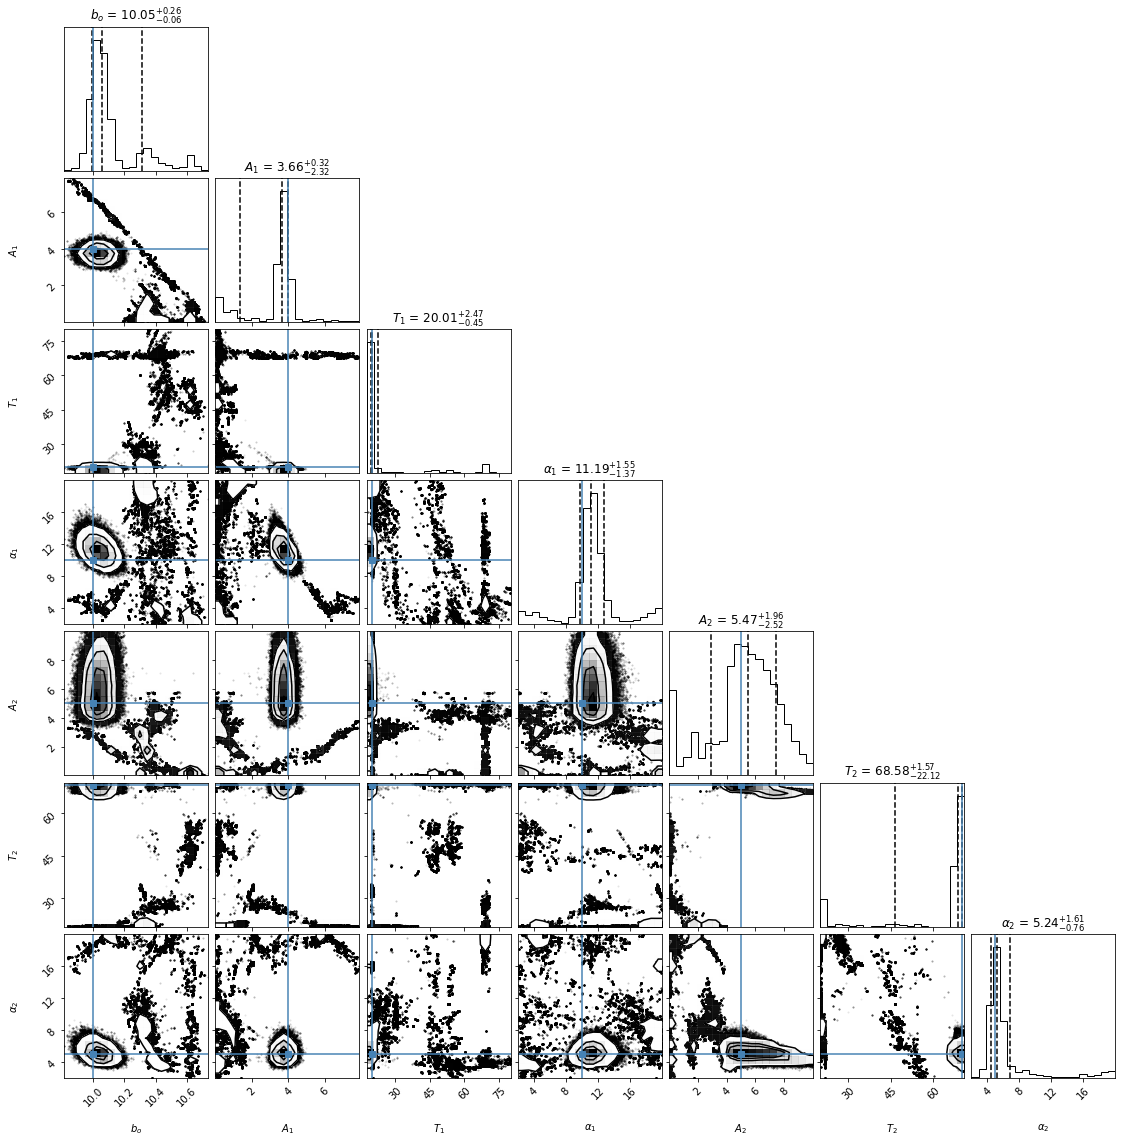

In [14]:
samples = np.vstack([emcee_trace[k] for k in range(0,ndim)]).T
Ls = [r"$b_o$", r"$A_1$", r"$T_1$", r"$\alpha_1$", r"$A_2$", r"$T_2$", r"$\alpha_2$"]  
corner.corner(samples, truths=thetaTrue, labels=Ls, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});

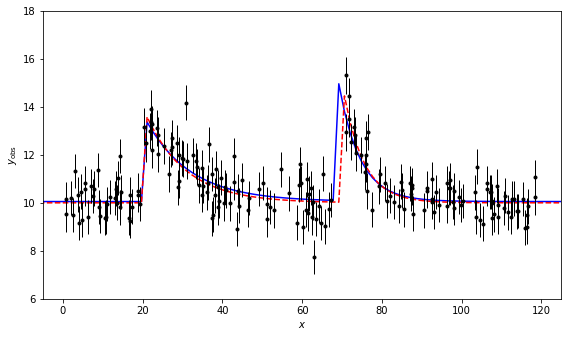

In [15]:
# Plot input data again, this time showing the true generative model
#  (which at the same time checks that the model and true params are set properly)
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])

xfit = np.linspace(-10,130,100)
yfit = yModel(xfit, thetaFit)
yTrue = yModel(xfit, thetaTrue)
plt.plot(xfit, yfit, c='b')
plt.plot(xfit, yTrue,  '--', c='r')

ax.errorbar(xdata, ydata, yErr, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

## Now we need to: 
#### 1) find the best fit for a single-burst model
#### 2) compare BIC for the two models and decide which one is better



In [16]:
## we will need best fit for both models, so let's store the double-burst fit just in case...
thetaFitDoubleBurst = thetaFit
yfitDoubleBurst = yModel(xdata, thetaFitDoubleBurst)
chi2DoubleBurst = np.sum(((ydata-yfitDoubleBurst)/yErr)**2) 
NparamDoubleBurst = 7
BICdb = chi2DoubleBurst + NparamDoubleBurst *np.log(np.size(xdata))
print('Double Burst: chi2 =', chi2DoubleBurst, 'BIC =', BICdb)

Double Burst: chi2 = 189.92972496375404 BIC = 227.0179465295903


## Let's redo emcee steps for single burst model...

In [17]:
# we will now fit "wrong" model to the same data (which was generated with a double-burst model)
def yModel(x, theta):
    return yModelSingle(x, theta)

In [18]:
# limits for flat priors
thetaMin =  (8,  0, 10,  2)
thetaMax = (12, 10, 80, 20)
ndim = 4

# starting guesses for parameters 
np.random.seed(0)
starting_guesses = 0.1*np.random.random((nwalkers, ndim))
# set starting guesses at the center of flat priors
for k in range(np.size(thetaMin)):
    starting_guesses[:,k] += 0.5*(thetaMin[k]+thetaMax[k])

In [19]:
nburn = 2000    # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[xdata, ydata, yErr, thetaMin, thetaMax])
%time sampler.run_mcmc(starting_guesses, nsteps) 
print("done")

CPU times: user 39.8 s, sys: 312 ms, total: 40.1 s
Wall time: 40.9 s
done


In [20]:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
thetaFit= []
for k in range(ndim):
    thetaFit.append(np.median(emcee_trace[k]))
    print(thetaTrue[k], np.median(emcee_trace[k]), np.std(emcee_trace[k]), np.size(emcee_trace[k]))

10 10.380613362948385 0.08597757117014503 800000
4 3.8242534250617237 2.0724758548292948 800000
20 20.394250561322664 24.398381010863936 800000
10 8.35330133010166 3.318465683409057 800000


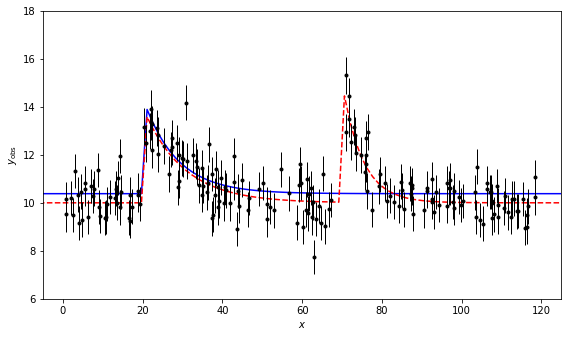

In [21]:
# Plot input data again, this time showing the true generative model
#  (which at the same time checks that the model and true params are set properly)
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])

xfit = np.linspace(-10,130,100)
yfit = yModel(xfit, thetaFit)
plt.plot(xfit, yfit, c='b')
plt.plot(xfit, yTrue,  '--', c='r')

ax.errorbar(xdata, ydata, yErr, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$y_{\rm obs}$')

plt.show()

In [22]:
## let's evaluate chi2 and BIC for the single-burst fit 
thetaFitSingleBurst = thetaFit
yfitSingleBurst = yModel(xdata, thetaFitSingleBurst)
chi2SingleBurst = np.sum(((ydata-yfitSingleBurst)/yErr)**2) 
NparamSingleBurst = 4
BICsb = chi2SingleBurst + NparamSingleBurst *np.log(np.size(xdata))

In [23]:
print ("             MODEL                   CHI2            BIC")
print ('    best single burst model:', chi2SingleBurst, BICsb)
print ('    best double burst model:', chi2DoubleBurst, BICdb)

             MODEL                   CHI2            BIC
    best single burst model: 362.3681410015299 383.56141046772206
    best double burst model: 189.92972496375404 227.0179465295903


### For completeness...

Another useful method for model selection is the **cross-validation method**.
Its disadvantage is that it may be computationally intensive for complex
problems, but its great advantage is that it is conceptually simple and
easy to implement (for details see textbook, $\S$8.11.1). The basic idea of 
the cross-validation method is not to use a fraction of the sample when
obtaining the best-fit parameters and then compute the goodness-of-fit 
(e.g. $\chi^2$, but any metric can be implemented) with this unused subsample. 
The "leave-one-out" implementation repeats model fitting $N$ times, using
$N-1$ data points. Each time the missing point is used to compute the 
goodness-of-fit, and the $N$ values are averaged. 

When the model is too simple, it will have high bias (under-fitting)
and when the model is too complex, the variance will be high (over-fitting).


![BayesSlide1](figures/fig8-13.tiff)




##  Bayesian Blocks Algorithm (not really an MCMC application) <a id='MS2mcmc'></a>
[Go to top](#toc)

Classical histogram methods, such as the Freedman–Diaconis and Knuth's methods,
assume a constant bin width (the former is inferior to the latter because it produces the same answer for multimodal and unimodal distributions as long as their data set size and scale parameter are the same). This limitation can be lifted by maximizing a well-designed likelihood function over bins of varying width. This approach has been dubbed Bayesian blocks. The method was first developed in the field of time-domain analysis (by Jeff Scargle), but is readily applicable to histogram data as well. 

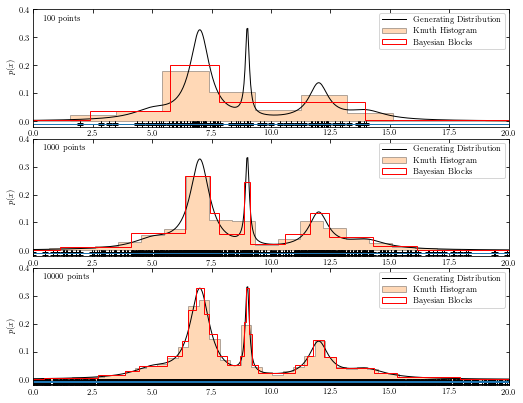

In [24]:
from scipy import stats
from astroML.plotting import hist
np.random.seed(42)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)



# Generate sample: a mix of several Cauchy distributions
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (100, 1000, 10000)
subplots = (311, 312, 313)

for N, subplot in zip(N_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    # plot the results
    ax.errorbar(xN, -0.01 + 0*xN, xerr=0.0, yerr=0.005, ecolor='black', lw=1)
    ax.plot(t, true_pdf(t), '-', color='black', lw=1,
            label="Generating Distribution")
    hist(xN, bins='knuth', ax=ax, density=True,
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
    hist(xN, bins='blocks', ax=ax, density=True,
         histtype='step', color='red', alpha=0.99,
         label="Bayesian Blocks")
  
    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right', prop=dict(size=8))

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.02, 0.4001)

plt.show()

Note that for largest sample (N=10,000), both methods give similar results (e.g. three components are found in the data). However, for the middle dataset (N=1,000), the fixed bin width method misses the middle peak - this could be your missed Nobel prize!

[Go to top](#toc)